### Wasserstein GAN (gradient-penalty version)

* GAN-training: as per Arjovsky et al. (2017), with the simplest possible setup.
* Architecture:
    * Discriminator: two CNN layers, two FC layers, outputs logits.
    * Generator: four-layered DeConv Net.
* Comments:
    * Gradient penalty: Gulrajani et al. (2017) Improved training of WGAN.
    * Leaky-ReLU + Layer Norm, as recommended by Gulrajani/17, do improve performance.

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

### Prepare data

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Image count: 55000 | Image pixel size: 784
Image sample:


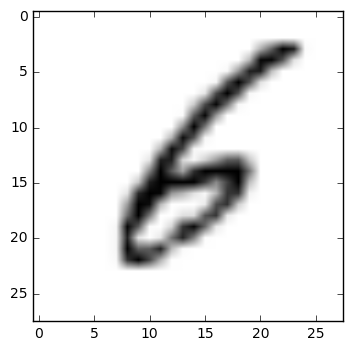

In [2]:
mnist = input_data.read_data_sets("MNIST_data/")
x_train = mnist.train.images[:55000,:]
print("Image count: {} | Image pixel size: {}".format(*x_train.shape))
print("Image sample:")
plt.imshow(x_train[random.randint(0,len(x_train))].reshape([28,28]),
           cmap='gray_r')
plt.show()

### Discriminator

In [40]:
def conv2d(x, n_out, k_size, stride, activation):
    return tf.contrib.layers.conv2d(
        x, n_out, k_size, stride,
        weights_initializer=tf.random_normal_initializer(stddev=0.01),
        activation_fn=activation
    )

def fc(x, n_out, activation):
    return tf.contrib.layers.fully_connected(
        x, n_out, 
        weights_initializer=tf.random_normal_initializer(stddev=0.01),
        activation_fn=activation
    )

# def dropout_relu(x, keep_prob=0.7):
#     return tf.nn.dropout(tf.nn.relu(x), keep_prob)

def leaky_relu(x, alpha=0.2):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

def leaky_relu_layer_norm(x, alpha=0.2):
    return leaky_relu(tf.contrib.layers.layer_norm(x), alpha)

class D:
    
    def __init__(self):
        self.name = 'discriminator'
    
    def __call__(self, x, reuse=False):
        # x: <batch,height,width,in-channels>
        with tf.variable_scope(self.name) as scope:
            if reuse:
                scope.reuse_variables()
            # Conv-avgpool 1
            # conv1 = conv2d(x, n_out=8, k_size=[5,5], stride=[2,2], activation=dropout_relu)
            #   above replaced with leaky-relu + layer norm, as per the recommendation of Gulrajani/17.
            conv1 = conv2d(x, n_out=8, k_size=[5,5], stride=[2,2], activation=leaky_relu_layer_norm)
                # <batch,height,width,out-chn> = <?,14,14,8> (NB: 'SAME' conv)
            # conv2 = conv2d(conv1, n_out=16, k_size=[5,5], stride=[2,2], activation=dropout_relu)
            #   above replaced with leaky-relu + layer norm, as per the recommendation of Gulrajani/17.
            conv2 = conv2d(conv1, n_out=16, k_size=[5,5], stride=[2,2], activation=leaky_relu_layer_norm)
                # <batch,height,width,out-chn> = <?,7,7,16>
            conv_flat = tf.contrib.layers.flatten(conv2)
                # <batch,height*width*out-chn>, dim-0 assumed to be batch size.
            fc1 = fc(conv_flat, 32, activation=tf.nn.relu)
                # <batch,32>
            fc2 = fc(fc1, 1, activation=tf.identity)
                # <batch,1>
        return fc2
    
    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

### Generator

In [41]:
class G:
    
    def __init__(self):
        self.name = 'generator'
    
    def __call__(self, z, batch_size, z_dim, keep_prob=1.0, reuse=False):
        # z: random noise input: <batch,z-dim>
        # batch-size,z-dim: explicitly put for debugging,
        #   but can be extracted at runtime with tf.unstack(tf.reshape(z)).
        with tf.variable_scope(self.name) as scope:
            if reuse:
                scope.reuse_variables()
            g_dim = 64 # num-filters of first layer of generator 
            c_dim = 1  # Color dimension of output (MNIST is grayscale, so c_dim = 1)
            s = 28     # Output size of the image
            s2, s4, s8, s16 = s//2, s//4, s//8, s//16 
                # Exponential image upscaling
                #   ^1 -> ^4 for gradual transition.
            h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
                # h0: <batch,height=2,width=2,in-chn=25>
                #   s16=28//16 = 1
            h0 = tf.nn.relu(h0)
            # DeConv-1
            output1_shape = [batch_size,s8,s8,g_dim*4]
                # out-shape: <batch,height=3,width=3,out-chn=64*4>
                #   s8=28//8 = 3
            W_conv1 = tf.get_variable('g_wconv1', [5,5,output1_shape[-1],int(h0.get_shape()[-1])], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
                # shape: <filter-height/batch,filter-width/num-pixels,out-channels,in-channels>
                #   NB: for deconv, in & out-channels switch place.
            b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], 
                                      initializer=tf.constant_initializer(.1))
            H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, 
                                             strides=[1,2,2,1], padding='SAME') + b_conv1
            H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, 
                                                   is_training=True, scope="g_bn1")
                # center,scale: (input-beta)/gamma
                #   beta,gamma initialized as mean and std.
            H_conv1 = tf.nn.dropout(tf.nn.relu(H_conv1),keep_prob)
                # <batch,height=3,width=3,out-chn=256>
            # DeConv-2
            output2_shape = [batch_size,s4-1,s4-1,g_dim*2]
                # out-shape: <batch,height=6,width=6,out-chn=64*2>
                #   s4=28//4 = 7
            W_conv2 = tf.get_variable('g_wconv2', [5,5,output2_shape[-1],int(H_conv1.get_shape()[-1])], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
            b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], 
                                      initializer=tf.constant_initializer(.1))
            H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                             strides=[1,2,2,1], padding='SAME') + b_conv2
            H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, 
                                                   is_training=True, scope="g_bn2")
            H_conv2 = tf.nn.dropout(tf.nn.relu(H_conv2),keep_prob)
                # <batch,height=6,width=6,out-chn=128>
            # DeConv-3
            output3_shape = [batch_size,s2-2,s2-2,g_dim*1]
                # out-shape: <batch,height=12,width=12,out-chn=64*1>
                #   s2=28//2 = 14
            W_conv3 = tf.get_variable('g_wconv3', [5,5,output3_shape[-1],int(H_conv2.get_shape()[-1])], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
            b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], 
                                      initializer=tf.constant_initializer(.1))
            H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                             strides=[1,2,2,1], padding='SAME') + b_conv3
            H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, 
                                                   is_training=True, scope="g_bn3")
            H_conv3 = tf.nn.dropout(tf.nn.relu(H_conv3),keep_prob)
                # <batch,height=12,width=12,out-chn=64>
            # DeConv-final
            output4_shape = [batch_size,s,s,c_dim]
                # out-shape: <batch,height=28,width=28,out-chn=1>
                #   s=28
                #   original data shape restored now.
            W_conv4 = tf.get_variable('g_wconv4', [5,5,output4_shape[-1],int(H_conv3.get_shape()[-1])], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
            b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
            H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                             strides=[1,2,2,1], padding='VALID') + b_conv4
            H_conv4 = tf.nn.dropout(tf.nn.tanh(H_conv4),keep_prob)
                # <batch,height=28,width=28,out-chn=1>
        return H_conv4 
    
    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

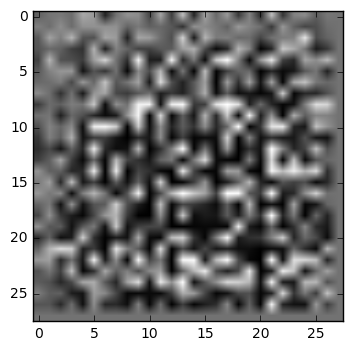

In [7]:
# Results from generator prior to training

tf.reset_default_graph()
sess = tf.Session()

z_dimensions = 100 # 100D random noise.
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
g_net = G()
sample_image = g_net(z_test_placeholder, 1, z_dimensions)
test_z = np.random.normal(-1, 1, [1,z_dimensions])
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z})) 
    # <batch-size=1,height=28,width=28,chn=1>
my_i = temp.squeeze() # get rid of all dim-1's. -> <28,28>
plt.imshow(my_i, cmap='gray_r')
plt.show()

### Wasserstein GAN (improved, with gradient penalty)

In [44]:
# Build graph

tf.reset_default_graph()

sess = tf.Session()

BATCH_SIZE = 32

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1]) # input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])   # input noise vectors to the generator

d_net = D()
g_net = G()

Dx = d_net(x_placeholder) 
    # <batch,1>
    #   predicted (unscale) probabilities for the real images (i.e. logits).
Gz = g_net(z_placeholder, BATCH_SIZE, z_dimensions) 
    # <batch,height=28,width=28,chn=1>
    #   the generated images.
Dg = d_net(Gz, reuse=True) # i.e. D(Gz)
    # <batch,1>
    #   discriminator prediction probabilities for generated images.
# >> Dx, Gz, Dg
# (<tf.Tensor 'discriminator/Add:0' shape=(?, 1) dtype=float32>,
#  <tf.Tensor 'generator/Tanh:0' shape=(16, 28, 28, 1) dtype=float32>,
#  <tf.Tensor 'discriminator_1/Add:0' shape=(16, 1) dtype=float32>)

# Approximating the Earth Mover (EM) distance
d_loss = tf.reduce_mean(Dx) - tf.reduce_mean(Dg)
g_loss = tf.reduce_mean(Dg)

# Gradient penalty
#   Gulrajani et al. (2017), Algorithm 1.
#   \lambda * (||grad(D(x_hat))||_2 - 1.0)**2
epsilon = tf.random_uniform([], 0.0, 1.0)            # get random number.
x_hat = epsilon*x_placeholder + (1-epsilon)*Gz       # compute x_hat by interpolation.
Dx_hat = d_net(x_hat, reuse=True)                    # compute D_w(x_hat).
scale = 10.0                                         # set scale=\lambda.
dDx = tf.gradients(Dx_hat, x_hat)[0]                 # compute grad(D(x_hat)).
dDx = tf.sqrt(tf.reduce_sum(tf.square(dDx), axis=1)) # compute ||grad(D(x_hat))||_2.
dDx = tf.reduce_mean(tf.square(dDx - 1.0) * scale)   # compute final penalty term.
d_loss = d_loss + dDx                                # apply to original loss.

# # Regularization (optional, usually better w/o when dataset's simple)
# reg = tf.contrib.layers.apply_regularization(
#     tf.contrib.layers.l1_regularizer(1e-5),
#     weights_list=[var for var in tf.global_variables()]
# )
# d_loss_reg = d_loss + reg
# g_loss_reg = g_loss + reg

# Create optimizers for D & G
adam = tf.train.AdamOptimizer(2e-4)
trainer_D = adam.minimize(d_loss, var_list=d_net.vars)
trainer_G = adam.minimize(g_loss, var_list=g_net.vars)

sess.run(tf.global_variables_initializer())

In [45]:
# Visualization validation

def validate():
    sample_image = g_net(z_placeholder, 1, z_dimensions, reuse=True)
    z_batch = np.random.normal(-1, 1, size=[1, z_dimensions])
    temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
    my_i = temp.squeeze()
    print("Image sample:")
    plt.imshow(my_i, cmap='gray_r')
    plt.show()

Epoch 1:

Loss at step 200: D-loss = -21.30199432373047 | G-loss = -56.068058013916016
Loss at step 400: D-loss = -47.54612731933594 | G-loss = -17.47573471069336
Loss at step 600: D-loss = -30.472997665405273 | G-loss = -9.494585037231445
Loss at step 800: D-loss = -33.03045654296875 | G-loss = -13.88288688659668
Loss at step 1000: D-loss = -30.28759002685547 | G-loss = -7.736721038818359
Loss at step 1200: D-loss = -39.459136962890625 | G-loss = 14.509818077087402
Loss at step 1400: D-loss = -29.474016189575195 | G-loss = -21.032188415527344
Loss at step 1600: D-loss = -27.796695709228516 | G-loss = -12.66016674041748
Loss at step 1800: D-loss = -21.48735809326172 | G-loss = -28.251178741455078
Loss at step 2000: D-loss = -24.920150756835938 | G-loss = -41.79630661010742
Loss at step 2200: D-loss = -24.486236572265625 | G-loss = -43.09556579589844
Loss at step 2400: D-loss = -24.774887084960938 | G-loss = -46.92027282714844
Loss at step 2600: D-loss = -20.32932472229004 | G-loss = -3

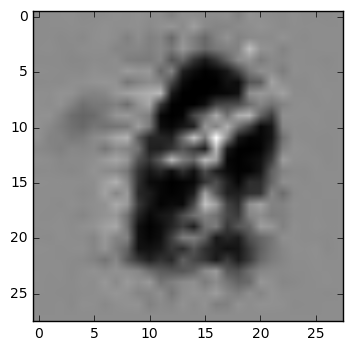

Epoch 2:

Loss at step 200: D-loss = -18.481443405151367 | G-loss = -40.77267074584961
Loss at step 400: D-loss = -15.852655410766602 | G-loss = -28.625370025634766
Loss at step 600: D-loss = -8.051606178283691 | G-loss = -27.564714431762695
Loss at step 800: D-loss = -14.25003433227539 | G-loss = -16.21723747253418
Loss at step 1000: D-loss = -15.54460620880127 | G-loss = -9.756053924560547
Loss at step 1200: D-loss = -16.303260803222656 | G-loss = 6.299004554748535
Loss at step 1400: D-loss = -14.183316230773926 | G-loss = 16.907920837402344
Loss at step 1600: D-loss = -16.529401779174805 | G-loss = 17.3848819732666
Loss at step 1800: D-loss = -12.097978591918945 | G-loss = 27.878421783447266
Loss at step 2000: D-loss = -8.845885276794434 | G-loss = 20.895313262939453
Loss at step 2200: D-loss = -17.70586395263672 | G-loss = 18.387252807617188
Loss at step 2400: D-loss = -16.03736114501953 | G-loss = 24.093080520629883
Loss at step 2600: D-loss = -12.490585327148438 | G-loss = 29.546

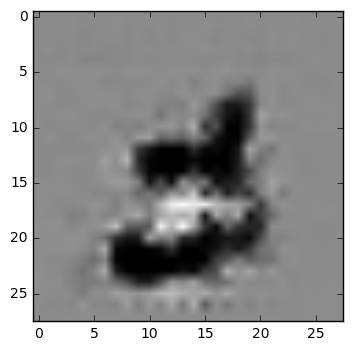

Epoch 3:

Loss at step 200: D-loss = -13.543244361877441 | G-loss = 27.335494995117188
Loss at step 400: D-loss = -13.153009414672852 | G-loss = 19.94972038269043
Loss at step 600: D-loss = -9.429771423339844 | G-loss = 21.066591262817383
Loss at step 800: D-loss = -8.24462890625 | G-loss = 32.76653289794922
Loss at step 1000: D-loss = -7.1895318031311035 | G-loss = 29.480663299560547
Loss at step 1200: D-loss = -10.886454582214355 | G-loss = 18.975059509277344
Loss at step 1400: D-loss = -15.36755084991455 | G-loss = 18.386926651000977
Loss at step 1600: D-loss = -8.711251258850098 | G-loss = 7.856781005859375
Loss at step 1800: D-loss = -12.496673583984375 | G-loss = 22.94256591796875
Loss at step 2000: D-loss = -8.408995628356934 | G-loss = 7.804230690002441
Loss at step 2200: D-loss = -7.60288143157959 | G-loss = 24.194828033447266
Loss at step 2400: D-loss = -12.550567626953125 | G-loss = 21.19829559326172
Loss at step 2600: D-loss = -11.278788566589355 | G-loss = 13.7122211456298

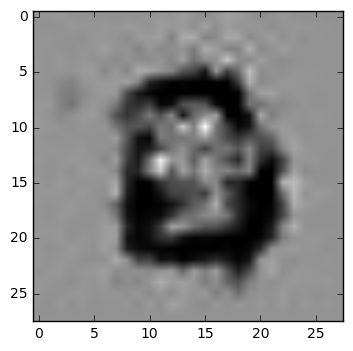

Epoch 4:

Loss at step 200: D-loss = -6.139165878295898 | G-loss = 6.847627639770508
Loss at step 400: D-loss = -0.3020505905151367 | G-loss = 9.40310001373291
Loss at step 600: D-loss = -8.653608322143555 | G-loss = 6.669937610626221
Loss at step 800: D-loss = -7.070770263671875 | G-loss = 3.1949968338012695
Loss at step 1000: D-loss = 0.5175380706787109 | G-loss = 3.736356258392334
Loss at step 1200: D-loss = -5.337700843811035 | G-loss = 12.688833236694336
Loss at step 1400: D-loss = -11.056475639343262 | G-loss = 5.126433849334717
Loss at step 1600: D-loss = -6.368963241577148 | G-loss = -2.2772834300994873
Loss at step 1800: D-loss = -6.461004734039307 | G-loss = 2.7306766510009766
Loss at step 2000: D-loss = -6.184696674346924 | G-loss = -0.872058629989624
Loss at step 2200: D-loss = 0.5350189208984375 | G-loss = -1.1638031005859375
Loss at step 2400: D-loss = -7.944387435913086 | G-loss = -3.2649474143981934
Loss at step 2600: D-loss = -3.7356677055358887 | G-loss = 7.6907124519

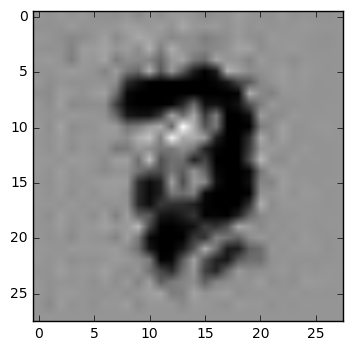

Epoch 5:

Loss at step 200: D-loss = -8.54386043548584 | G-loss = 4.94887638092041
Loss at step 400: D-loss = -3.256798267364502 | G-loss = -1.488105058670044
Loss at step 600: D-loss = -6.794969081878662 | G-loss = -1.2682545185089111
Loss at step 800: D-loss = -5.165813446044922 | G-loss = -9.007501602172852
Loss at step 1000: D-loss = -8.414979934692383 | G-loss = -1.6229547262191772
Loss at step 1200: D-loss = -6.5741496086120605 | G-loss = 1.4594531059265137
Loss at step 1400: D-loss = -6.750227451324463 | G-loss = -0.24998587369918823
Loss at step 1600: D-loss = -8.118189811706543 | G-loss = 2.5975868701934814
Loss at step 1800: D-loss = -4.574688911437988 | G-loss = -2.873018264770508
Loss at step 2000: D-loss = -5.121122360229492 | G-loss = -4.03458833694458
Loss at step 2200: D-loss = -5.6963725090026855 | G-loss = -4.440746784210205
Loss at step 2400: D-loss = -4.658193111419678 | G-loss = -0.7102689743041992
Loss at step 2600: D-loss = -6.796621322631836 | G-loss = -7.646847

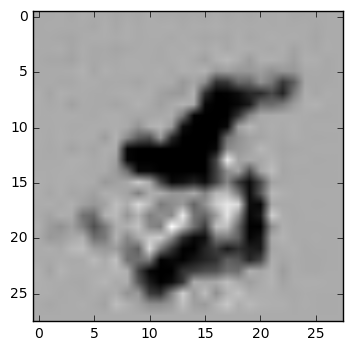

Epoch 6:

Loss at step 200: D-loss = -5.701502323150635 | G-loss = -3.5297493934631348
Loss at step 400: D-loss = -5.0594377517700195 | G-loss = -6.079171180725098
Loss at step 600: D-loss = -2.458150625228882 | G-loss = -2.6314547061920166
Loss at step 800: D-loss = -4.123034477233887 | G-loss = -0.02305985987186432
Loss at step 1000: D-loss = -5.666165351867676 | G-loss = 1.3027474880218506
Loss at step 1200: D-loss = -4.495975494384766 | G-loss = 1.2127526998519897
Loss at step 1400: D-loss = -5.0678205490112305 | G-loss = -3.966525077819824
Loss at step 1600: D-loss = -5.86293363571167 | G-loss = -4.7563090324401855
Loss at step 1800: D-loss = -3.990339994430542 | G-loss = -5.844054698944092
Loss at step 2000: D-loss = -3.757572889328003 | G-loss = 0.8466508388519287
Loss at step 2200: D-loss = -4.091549873352051 | G-loss = 4.6528120040893555
Loss at step 2400: D-loss = -4.331284999847412 | G-loss = 6.078521728515625
Loss at step 2600: D-loss = -4.717292308807373 | G-loss = 2.19558

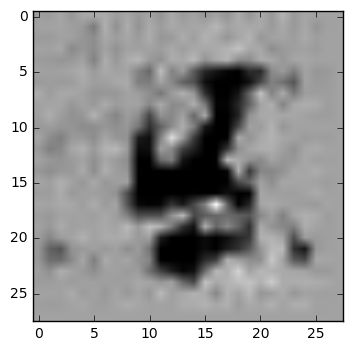

Epoch 7:

Loss at step 200: D-loss = -3.3107779026031494 | G-loss = 0.90290367603302
Loss at step 400: D-loss = -2.000429630279541 | G-loss = 4.07621955871582
Loss at step 600: D-loss = -2.8340682983398438 | G-loss = 1.9522719383239746
Loss at step 800: D-loss = -6.0185346603393555 | G-loss = 6.399603843688965
Loss at step 1000: D-loss = -4.450894355773926 | G-loss = 7.980838775634766
Loss at step 1200: D-loss = -2.0563790798187256 | G-loss = 4.289262771606445
Loss at step 1400: D-loss = -4.813499450683594 | G-loss = 4.109050750732422
Loss at step 1600: D-loss = -2.9187850952148438 | G-loss = -0.6630183458328247
Loss at step 1800: D-loss = -3.473653793334961 | G-loss = 5.4846882820129395
Loss at step 2000: D-loss = -5.119627952575684 | G-loss = -1.3896026611328125
Loss at step 2200: D-loss = -3.827998399734497 | G-loss = 4.966261863708496
Loss at step 2400: D-loss = -3.2683844566345215 | G-loss = 2.8878207206726074
Loss at step 2600: D-loss = -3.3735921382904053 | G-loss = 6.2087297439

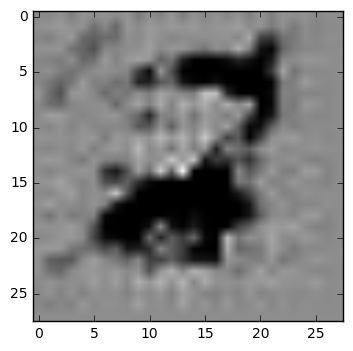

Epoch 8:

Loss at step 200: D-loss = -1.7996306419372559 | G-loss = 3.6685914993286133
Loss at step 400: D-loss = -1.7834136486053467 | G-loss = 4.096665382385254
Loss at step 600: D-loss = -2.0553250312805176 | G-loss = 5.484462261199951
Loss at step 800: D-loss = -3.809195041656494 | G-loss = 0.8225487470626831
Loss at step 1000: D-loss = -2.858262538909912 | G-loss = -7.410980701446533
Loss at step 1200: D-loss = -3.0719411373138428 | G-loss = -5.227762222290039
Loss at step 1400: D-loss = -3.6243014335632324 | G-loss = 0.8243306875228882
Loss at step 1600: D-loss = -3.004110813140869 | G-loss = -2.714477300643921
Loss at step 1800: D-loss = -5.204784870147705 | G-loss = -3.8814167976379395
Loss at step 2000: D-loss = -4.478168487548828 | G-loss = -7.265687942504883
Loss at step 2200: D-loss = -2.5117363929748535 | G-loss = 1.1877609491348267
Loss at step 2400: D-loss = -4.01650333404541 | G-loss = -1.345842957496643
Loss at step 2600: D-loss = -4.0211029052734375 | G-loss = -1.4517

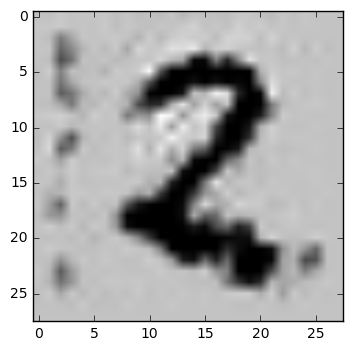

Epoch 9:

Loss at step 200: D-loss = -3.402182102203369 | G-loss = -8.80810546875
Loss at step 400: D-loss = -2.569634437561035 | G-loss = -7.165400505065918
Loss at step 600: D-loss = -1.6464207172393799 | G-loss = -9.225379943847656
Loss at step 800: D-loss = -2.305713176727295 | G-loss = -6.47017765045166
Loss at step 1000: D-loss = -0.9365208148956299 | G-loss = -11.183162689208984
Loss at step 1200: D-loss = -1.5641281604766846 | G-loss = -7.304124355316162
Loss at step 1400: D-loss = -2.1479544639587402 | G-loss = -1.0165624618530273
Loss at step 1600: D-loss = -1.538842797279358 | G-loss = -7.212924003601074
Loss at step 1800: D-loss = -4.136174201965332 | G-loss = -21.675811767578125
Loss at step 2000: D-loss = -2.830467700958252 | G-loss = -7.251946449279785
Loss at step 2200: D-loss = -2.0002565383911133 | G-loss = -6.476181983947754
Loss at step 2400: D-loss = -3.7676029205322266 | G-loss = -9.28537368774414
Loss at step 2600: D-loss = -1.4748773574829102 | G-loss = -16.0532

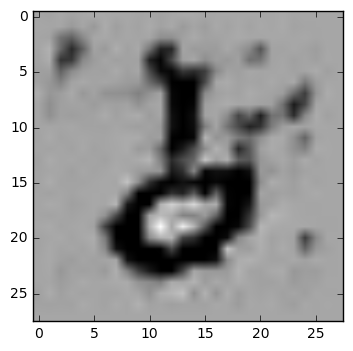

Epoch 10:

Loss at step 200: D-loss = -2.9976806640625 | G-loss = -12.901670455932617
Loss at step 400: D-loss = -0.5381021499633789 | G-loss = -7.35789155960083
Loss at step 600: D-loss = -1.4664113521575928 | G-loss = -11.52064037322998
Loss at step 800: D-loss = -2.333090305328369 | G-loss = -14.066183090209961
Loss at step 1000: D-loss = -2.785022258758545 | G-loss = -13.046272277832031
Loss at step 1200: D-loss = -3.142000436782837 | G-loss = -7.352179527282715
Loss at step 1400: D-loss = -1.1830055713653564 | G-loss = -14.768078804016113
Loss at step 1600: D-loss = -0.9580645561218262 | G-loss = -15.111551284790039
Loss at step 1800: D-loss = 0.40459853410720825 | G-loss = -8.432245254516602
Loss at step 2000: D-loss = -1.4309325218200684 | G-loss = -9.875736236572266
Loss at step 2200: D-loss = -0.9467463493347168 | G-loss = -4.52628231048584
Loss at step 2400: D-loss = -3.549347400665283 | G-loss = -10.231579780578613
Loss at step 2600: D-loss = -1.4338432550430298 | G-loss = -

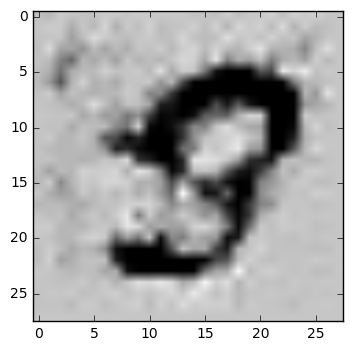

Epoch 11:

Loss at step 200: D-loss = -1.5202707052230835 | G-loss = -9.975679397583008
Loss at step 400: D-loss = -1.6570665836334229 | G-loss = -2.299974203109741
Loss at step 600: D-loss = -0.24234157800674438 | G-loss = -12.745951652526855
Loss at step 800: D-loss = -2.658057451248169 | G-loss = -17.559236526489258
Loss at step 1000: D-loss = -1.7315329313278198 | G-loss = -5.953780174255371
Loss at step 1200: D-loss = -0.9529698491096497 | G-loss = -19.923439025878906
Loss at step 1400: D-loss = -0.5679545402526855 | G-loss = -9.791707992553711
Loss at step 1600: D-loss = -3.122952938079834 | G-loss = -12.190177917480469
Loss at step 1800: D-loss = -0.6288716793060303 | G-loss = -9.202163696289062
Loss at step 2000: D-loss = -1.619065761566162 | G-loss = -6.9126152992248535
Loss at step 2200: D-loss = -1.2089641094207764 | G-loss = -14.656740188598633
Loss at step 2400: D-loss = -0.1952897310256958 | G-loss = -19.652633666992188
Loss at step 2600: D-loss = -0.19355559349060059 | G

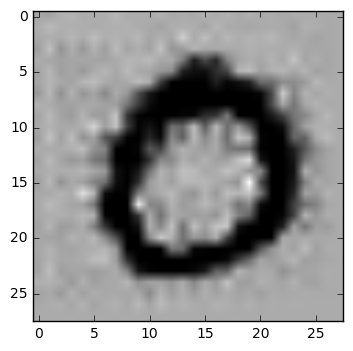

Epoch 12:

Loss at step 200: D-loss = -2.1382198333740234 | G-loss = -12.344377517700195
Loss at step 400: D-loss = -0.9009320735931396 | G-loss = -8.272130012512207
Loss at step 600: D-loss = -1.34954035282135 | G-loss = -13.43131160736084
Loss at step 800: D-loss = -1.79015052318573 | G-loss = -10.903787612915039
Loss at step 1000: D-loss = -1.4775700569152832 | G-loss = -9.97813606262207
Loss at step 1200: D-loss = -2.095808982849121 | G-loss = -14.050622940063477
Loss at step 1400: D-loss = -0.2521933615207672 | G-loss = -21.33728790283203
Loss at step 1600: D-loss = -2.053307056427002 | G-loss = -16.796226501464844
Loss at step 1800: D-loss = -2.4597535133361816 | G-loss = -16.718313217163086
Loss at step 2000: D-loss = 0.01624433696269989 | G-loss = -17.23593521118164
Loss at step 2200: D-loss = -2.9576992988586426 | G-loss = -21.69200325012207
Loss at step 2400: D-loss = -0.628619909286499 | G-loss = -19.50634002685547
Loss at step 2600: D-loss = -0.7368350625038147 | G-loss = -

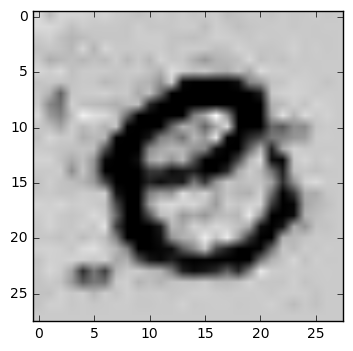

Epoch 13:

Loss at step 200: D-loss = -2.214005947113037 | G-loss = -24.822067260742188
Loss at step 400: D-loss = -2.1332592964172363 | G-loss = -20.959102630615234
Loss at step 600: D-loss = -1.7313964366912842 | G-loss = -18.329042434692383
Loss at step 800: D-loss = -2.4564857482910156 | G-loss = -25.530609130859375
Loss at step 1000: D-loss = -1.4088895320892334 | G-loss = -16.26795196533203
Loss at step 1200: D-loss = -0.592549741268158 | G-loss = -24.452253341674805
Loss at step 1400: D-loss = -0.9418860077857971 | G-loss = -30.73149871826172
Loss at step 1600: D-loss = -1.0300123691558838 | G-loss = -24.103342056274414
Loss at step 1800: D-loss = -1.2719061374664307 | G-loss = -20.04534149169922
Loss at step 2000: D-loss = -1.000945806503296 | G-loss = -24.635740280151367
Loss at step 2200: D-loss = -1.5089421272277832 | G-loss = -21.840606689453125
Loss at step 2400: D-loss = -1.9196486473083496 | G-loss = -11.594091415405273
Loss at step 2600: D-loss = -2.7199807167053223 | G

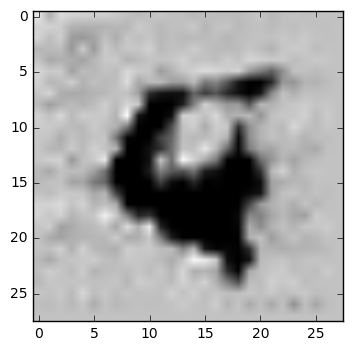

Epoch 14:

Loss at step 200: D-loss = -1.2215254306793213 | G-loss = -18.12286949157715
Loss at step 400: D-loss = -2.704976797103882 | G-loss = -17.385496139526367
Loss at step 600: D-loss = -1.3694170713424683 | G-loss = -18.58937644958496
Loss at step 800: D-loss = -0.3780491352081299 | G-loss = -22.957015991210938
Loss at step 1000: D-loss = 0.08673983812332153 | G-loss = -24.884859085083008
Loss at step 1200: D-loss = 1.1764583587646484 | G-loss = -10.747586250305176
Loss at step 1400: D-loss = -2.8447375297546387 | G-loss = -19.272197723388672
Loss at step 1600: D-loss = 0.27541738748550415 | G-loss = -27.924808502197266
Loss at step 1800: D-loss = 1.4347150325775146 | G-loss = -38.687530517578125
Loss at step 2000: D-loss = -1.6429752111434937 | G-loss = -18.62784194946289
Loss at step 2200: D-loss = -0.607640266418457 | G-loss = -30.20430564880371
Loss at step 2400: D-loss = -1.560331106185913 | G-loss = -14.16942024230957
Loss at step 2600: D-loss = -0.6857385635375977 | G-los

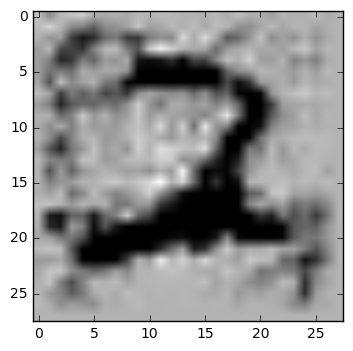

Epoch 15:

Loss at step 200: D-loss = -0.8902093172073364 | G-loss = -27.342208862304688
Loss at step 400: D-loss = -6.147646903991699 | G-loss = -43.404701232910156
Loss at step 600: D-loss = -2.025230646133423 | G-loss = -22.096702575683594
Loss at step 800: D-loss = -3.700483798980713 | G-loss = -33.55147171020508
Loss at step 1000: D-loss = -0.7893480658531189 | G-loss = -21.6351375579834
Loss at step 1200: D-loss = -0.965919017791748 | G-loss = -41.26171112060547
Loss at step 1400: D-loss = -2.344245433807373 | G-loss = -29.236358642578125
Loss at step 1600: D-loss = -0.5221807360649109 | G-loss = -39.70843505859375
Loss at step 1800: D-loss = -2.2358572483062744 | G-loss = -17.38521385192871
Loss at step 2000: D-loss = 0.5137606859207153 | G-loss = -19.785335540771484
Loss at step 2200: D-loss = 1.491065263748169 | G-loss = -22.774566650390625
Loss at step 2400: D-loss = -1.2527087926864624 | G-loss = -29.374826431274414
Loss at step 2600: D-loss = -0.3289799690246582 | G-loss = 

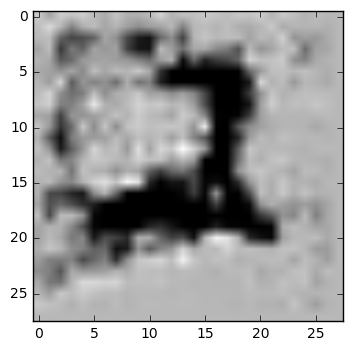

Epoch 16:

Loss at step 200: D-loss = -0.20240116119384766 | G-loss = -33.340087890625
Loss at step 400: D-loss = -2.0109646320343018 | G-loss = -30.90179443359375
Loss at step 600: D-loss = -2.010559320449829 | G-loss = -30.21289825439453
Loss at step 800: D-loss = -1.4290237426757812 | G-loss = -37.732933044433594
Loss at step 1000: D-loss = -0.46400177478790283 | G-loss = -39.64387512207031
Loss at step 1200: D-loss = -1.3299009799957275 | G-loss = -36.26906204223633
Loss at step 1400: D-loss = -3.03100848197937 | G-loss = -36.53028106689453
Loss at step 1600: D-loss = 0.31291675567626953 | G-loss = -30.54560089111328
Loss at step 1800: D-loss = -0.3222240209579468 | G-loss = -35.47315979003906
Loss at step 2000: D-loss = 0.2848452925682068 | G-loss = -37.2928581237793
Loss at step 2200: D-loss = -2.469592571258545 | G-loss = -39.659324645996094
Loss at step 2400: D-loss = -0.11796820163726807 | G-loss = -38.36536407470703
Loss at step 2600: D-loss = -0.828353226184845 | G-loss = -3

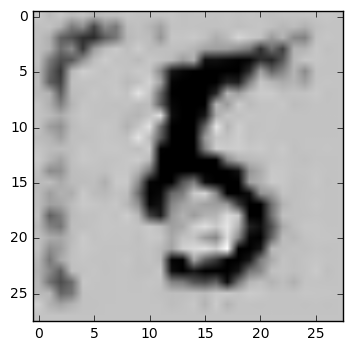

Epoch 17:

Loss at step 200: D-loss = -1.5243465900421143 | G-loss = -19.7343692779541
Loss at step 400: D-loss = -2.5089008808135986 | G-loss = -28.0255126953125
Loss at step 600: D-loss = -2.8270657062530518 | G-loss = -26.689002990722656
Loss at step 800: D-loss = -1.7357031106948853 | G-loss = -27.132593154907227
Loss at step 1000: D-loss = -2.222683906555176 | G-loss = -24.872482299804688
Loss at step 1200: D-loss = -1.3514223098754883 | G-loss = -23.920427322387695
Loss at step 1400: D-loss = -4.1518120765686035 | G-loss = -21.16868019104004
Loss at step 1600: D-loss = -0.5622888207435608 | G-loss = -30.625946044921875
Loss at step 1800: D-loss = -2.1185686588287354 | G-loss = -26.066200256347656
Loss at step 2000: D-loss = -2.419930934906006 | G-loss = -29.371444702148438
Loss at step 2200: D-loss = -2.7735605239868164 | G-loss = -24.409141540527344
Loss at step 2400: D-loss = -2.406550645828247 | G-loss = -28.673734664916992
Loss at step 2600: D-loss = -0.9428603649139404 | G-l

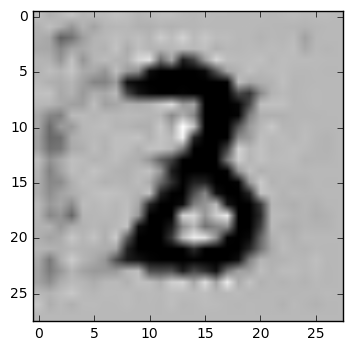

Epoch 18:

Loss at step 200: D-loss = -0.6564351320266724 | G-loss = -40.07841873168945
Loss at step 400: D-loss = -3.785153865814209 | G-loss = -35.64967346191406
Loss at step 600: D-loss = -1.7030165195465088 | G-loss = -33.28293991088867
Loss at step 800: D-loss = -1.9146918058395386 | G-loss = -31.38558006286621
Loss at step 1000: D-loss = -0.28490734100341797 | G-loss = -32.315494537353516
Loss at step 1200: D-loss = -2.1688857078552246 | G-loss = -23.234760284423828
Loss at step 1400: D-loss = -1.7481434345245361 | G-loss = -32.72065734863281
Loss at step 1600: D-loss = -1.4343640804290771 | G-loss = -24.898414611816406
Loss at step 1800: D-loss = -1.8943403959274292 | G-loss = -26.64263916015625
Loss at step 2000: D-loss = -1.239457607269287 | G-loss = -33.49555587768555
Loss at step 2200: D-loss = -2.2123758792877197 | G-loss = -28.173412322998047
Loss at step 2400: D-loss = -2.193129062652588 | G-loss = -29.766355514526367
Loss at step 2600: D-loss = -1.7329450845718384 | G-lo

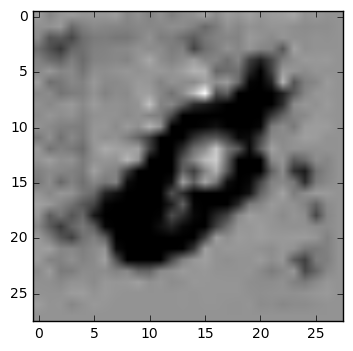

Epoch 19:

Loss at step 200: D-loss = -4.142458915710449 | G-loss = -38.70836639404297
Loss at step 400: D-loss = -6.597293376922607 | G-loss = -44.7313346862793
Loss at step 600: D-loss = -0.08555832505226135 | G-loss = -34.42530822753906
Loss at step 800: D-loss = -1.2498455047607422 | G-loss = -36.616844177246094
Loss at step 1000: D-loss = -1.7442798614501953 | G-loss = -41.190528869628906
Loss at step 1200: D-loss = -0.9464408159255981 | G-loss = -34.576805114746094
Loss at step 1400: D-loss = -2.2123939990997314 | G-loss = -30.471572875976562
Loss at step 1600: D-loss = -0.9895281791687012 | G-loss = -20.8828125
Loss at step 1800: D-loss = 0.6870921850204468 | G-loss = -28.323169708251953
Loss at step 2000: D-loss = -2.135814666748047 | G-loss = -37.93978500366211
Loss at step 2200: D-loss = 0.16406559944152832 | G-loss = -37.805458068847656
Loss at step 2400: D-loss = -2.017009973526001 | G-loss = -34.71088790893555
Loss at step 2600: D-loss = -0.6553412675857544 | G-loss = -28.

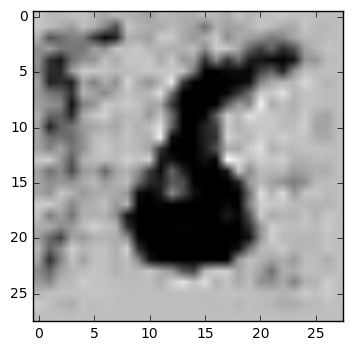

Epoch 20:

Loss at step 200: D-loss = -3.976322650909424 | G-loss = -28.381322860717773
Loss at step 400: D-loss = -0.6269344091415405 | G-loss = -33.77776336669922
Loss at step 600: D-loss = -2.132965087890625 | G-loss = -30.415435791015625
Loss at step 800: D-loss = -0.439116895198822 | G-loss = -25.550765991210938
Loss at step 1000: D-loss = -2.4569242000579834 | G-loss = -27.830669403076172
Loss at step 1200: D-loss = -3.8805861473083496 | G-loss = -40.334686279296875
Loss at step 1400: D-loss = -1.1863183975219727 | G-loss = -27.786205291748047
Loss at step 1600: D-loss = -1.7603036165237427 | G-loss = -28.06970977783203
Loss at step 1800: D-loss = -1.794961929321289 | G-loss = -29.2017822265625
Loss at step 2000: D-loss = 0.6213909387588501 | G-loss = -34.966346740722656
Loss at step 2200: D-loss = -0.8011816740036011 | G-loss = -31.20134925842285
Loss at step 2400: D-loss = -1.9566377401351929 | G-loss = -40.47801208496094
Loss at step 2600: D-loss = -1.1992988586425781 | G-loss

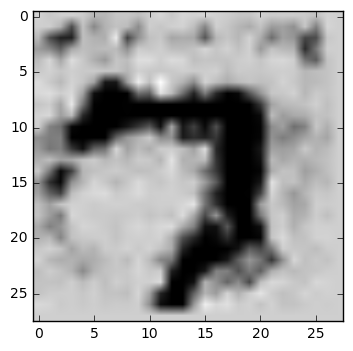

In [46]:
# Training
#   D-G alternation set to 5-1
#   i.e. 5 update of D and then 1 G update.

NUM_EPOCH = 20
NUM_ITERS = 3000
D_ITERS = 5
VERBOSE = 200

try:
    for e in range(NUM_EPOCH):
        print("Epoch {}:\n".format(e+1))
        d_loss_track, g_loss_track = [],[]
        for i in range(NUM_ITERS):
            sub_d_loss_track = []
            for di in range(D_ITERS):
                z_batch = np.random.normal(-1, 1, size=[BATCH_SIZE, z_dimensions])
                real_image_batch = np.reshape(mnist.train.next_batch(BATCH_SIZE)[0],
                                              [BATCH_SIZE,28,28,1])
                _,d_loss_ = sess.run([trainer_D, d_loss],feed_dict={z_placeholder:z_batch,
                                                                    x_placeholder:real_image_batch}) 
                sub_d_loss_track.append(d_loss_)
            z_batch = np.random.normal(-1, 1, size=[BATCH_SIZE, z_dimensions])
            _,g_loss_ = sess.run([trainer_G, g_loss],feed_dict={z_placeholder:z_batch}) 
            d_loss_track.append(np.mean(sub_d_loss_track))
            g_loss_track.append(g_loss_)
            if (i+1)%VERBOSE==0:
                print("Loss at step {}: D-loss = {} | G-loss = {}".format(i+1,d_loss_,g_loss_))
        print("\nEpoch average: D-loss = {} | G-loss = {}\n".format(np.mean(d_loss_track),
                                                                    np.mean(g_loss_track)))
        print('Validating...')
        validate()
except KeyboardInterrupt:
    print("Stopped!")

Image sample:


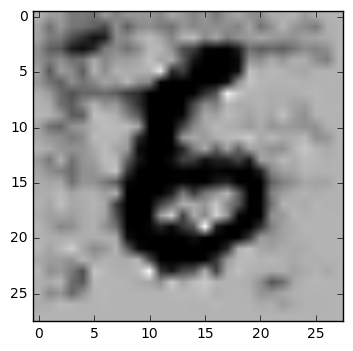

In [37]:
# Final validation

validate()